In [146]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [147]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [148]:
s = ctl.TransferFunction.s
G = 1/(1.59154943091895*s + 1.0)

G_bkp = G
G

TransferFunction(array([1]), array([1.59154943, 1.        ]))

polos:  (-0.628+0j)
zeros: 


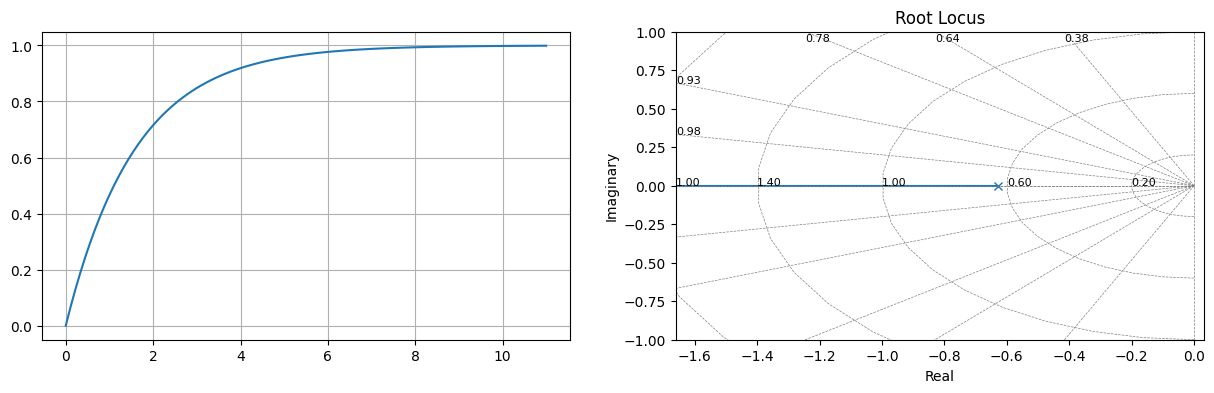

In [149]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [150]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 0.9990000000000006,
 'peakTime': 10.994033983191393,
 'settlingTime': 5.663593264068293,
 'finalValue': 0.9990000000000006,
 'error': 0.0009999999999994458}

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [151]:
s = ctl.TransferFunction.s

In [152]:
def getResponsePID(Kp, Ti, Td):
    C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_feedback = ctl.feedback(G*C, 1)

    time, response = ctl.step_response(G_feedback)
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

{'overshoot': 0.0006679097188690217,
 'peakValue': 1.0012133612457812,
 'peakTime': 8.986081778192395,
 'settlingTime': 4.914263472448965,
 'finalValue': 1.0005450874577015,
 'error': 0.000545087457701543,
 'Kp': 1,
 'Ti': 1,
 'Td': 1}

In [153]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [154]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

In [155]:
def displayLimits(df):
    display(df.head())
    print('settlingTime: ', (df.settlingTime.min().round(3), df.settlingTime.max().round(3)))
    print('overshoot:    ', (df.overshoot.min().round(3), df.overshoot.max().round(3)))
    print('error:        ', (df.error.min().round(3), df.error.max().round(3)))


df = pd.DataFrame(data)
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.248658,1.249872,4.312383,10.623398,1.000973,0.000973,0.01,0.01,0.010000
1,0.103862,1.104823,4.269702,6.852120,1.000871,0.000871,0.01,0.01,0.564444
2,0.029791,1.029696,4.444740,5.764794,0.999908,0.000092,0.01,0.01,1.118889
3,0.000000,0.992882,4.899356,3.109771,0.992882,0.007118,0.01,0.01,1.673333
4,0.000000,0.999823,17.814622,5.592292,0.999823,0.000177,0.01,0.01,2.227778


settlingTime:  (0.006, 1807.359)
overshoot:     (0.0, 0.466)
error:         (0.0, 0.106)


### ANÁLISE DOS DADOS

In [156]:
df = df.loc[(df.settlingTime > 0.2) & (df.settlingTime < 5.0)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
3,0.000000,0.992882,4.899356,3.109771,0.992882,0.007118,0.01,0.010000,1.673333
100,0.466417,1.465818,0.106475,0.529021,0.999592,0.000408,11.12,0.010000,0.010000
110,0.072612,1.073319,0.647111,1.350493,1.000659,0.000659,11.12,0.564444,0.010000
111,0.010949,1.011273,1.603386,0.690639,1.000321,0.000321,11.12,0.564444,0.564444
112,0.001334,1.001993,2.514089,0.768044,1.000659,0.000659,11.12,0.564444,1.118889


settlingTime:  (0.207, 4.795)
overshoot:     (0.0, 0.466)
error:         (0.0, 0.051)


In [157]:
df = df.loc[(df.overshoot > 0.0) & (df.overshoot < 0.3)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
110,0.072612,1.073319,0.647111,1.350493,1.000659,0.000659,11.12,0.564444,0.010000
111,0.010949,1.011273,1.603386,0.690639,1.000321,0.000321,11.12,0.564444,0.564444
112,0.001334,1.001993,2.514089,0.768044,1.000659,0.000659,11.12,0.564444,1.118889
120,0.001446,1.019780,0.899963,0.533311,1.018307,0.018307,11.12,1.118889,0.010000
121,0.003225,1.003448,2.817860,1.170224,1.000222,0.000222,11.12,1.118889,0.564444


settlingTime:  (0.238, 1.48)
overshoot:     (0.0, 0.073)
error:         (0.0, 0.018)


In [158]:
df = df.loc[(df.error > 0.0) & (df.error < 1.0)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
110,0.072612,1.073319,0.647111,1.350493,1.000659,0.000659,11.12,0.564444,0.010000
111,0.010949,1.011273,1.603386,0.690639,1.000321,0.000321,11.12,0.564444,0.564444
112,0.001334,1.001993,2.514089,0.768044,1.000659,0.000659,11.12,0.564444,1.118889
120,0.001446,1.019780,0.899963,0.533311,1.018307,0.018307,11.12,1.118889,0.010000
121,0.003225,1.003448,2.817860,1.170224,1.000222,0.000222,11.12,1.118889,0.564444


settlingTime:  (0.238, 1.48)
overshoot:     (0.0, 0.073)
error:         (0.0, 0.018)


In [159]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(11.12, 0.5644444444444445, 0.01)

# RESPOSTA CONTROLADA

In [160]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
C

TransferFunction(array([ 0.06276622,  6.38782222, 11.12      ]), array([0.00056444, 0.56444444, 0.        ]))

In [161]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 0.06276622,  6.38782222, 11.12      ]), array([8.98341234e-04, 8.98905679e-01, 5.64444444e-01, 0.00000000e+00]))

In [162]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 0.06276622,  6.38782222, 11.12      ]), array([8.98341234e-04, 9.61671901e-01, 6.95226667e+00, 1.11200000e+01]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [167]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-1063.23+0j), (-4.884+0j), (-2.384+0j)]

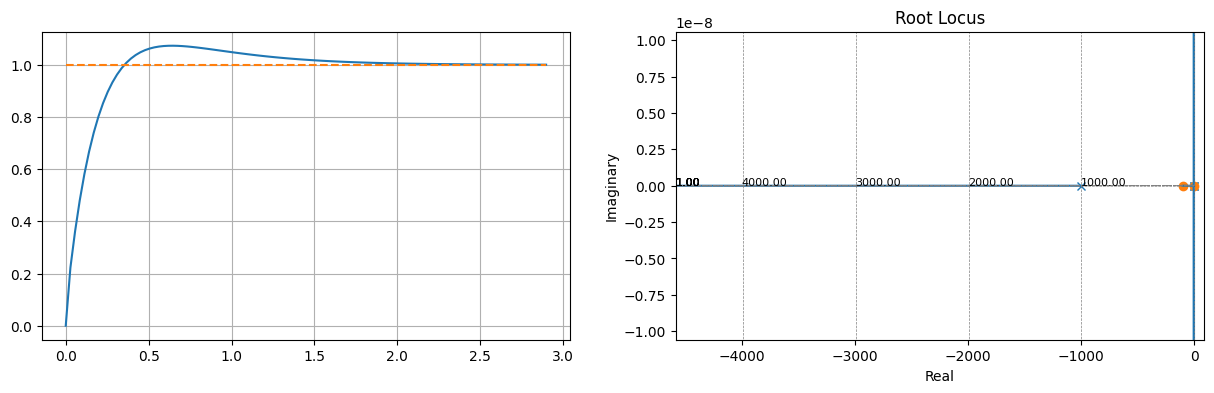

In [164]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [165]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.07261187029554687
valor de pico:  1.0733187585961785
tempo de pico:  0.6471114584539622
tempo de assentamento:  1.3504934785126168
valor final:  1.0006590345680557
erro:  0.0006590345680557164


# APLICANDO VÁRIOS STEPS

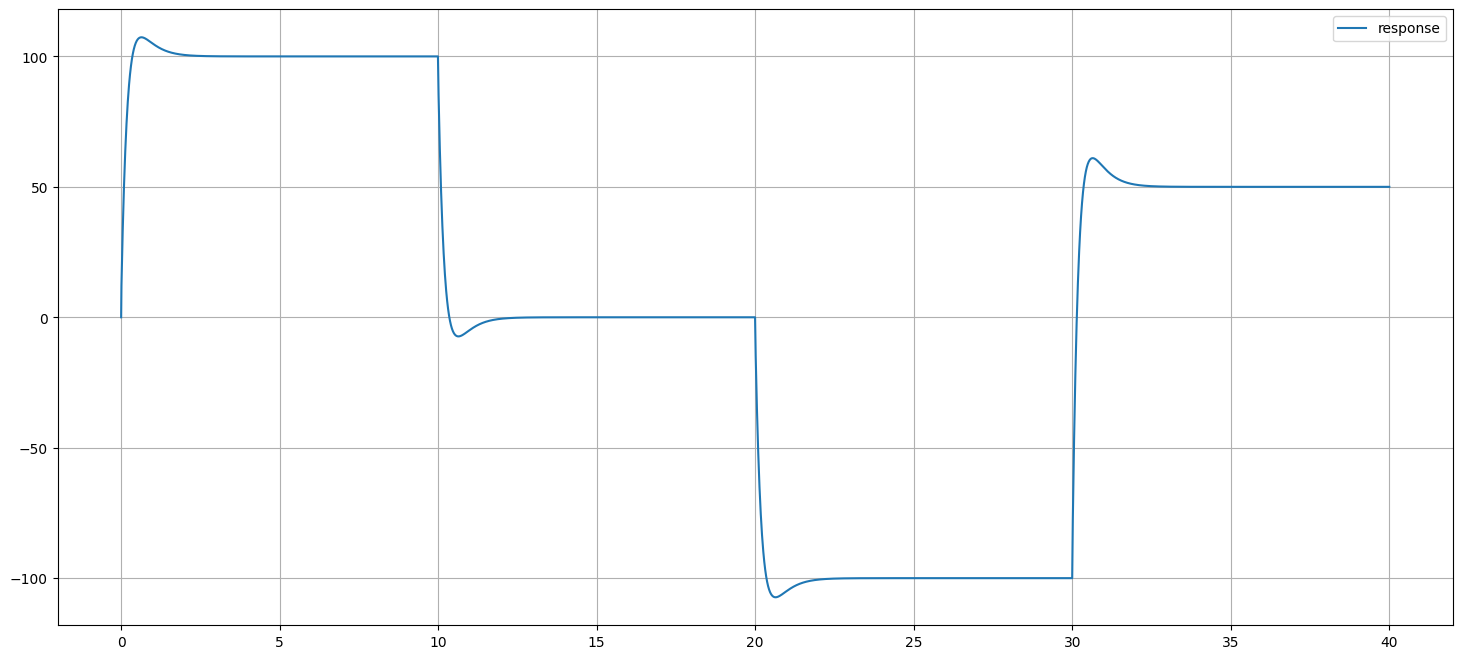

In [166]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()